# Main Analysis – Final Results

This notebook computes and displays key results for the EEG memory recognition study replication.

## Study Citation

**Delorme, A., Poncet, M., & Fabre-Thorpe, M. (2018).** Briefly Flashed Scenes Can Be Stored in Long-Term Memory. *Frontiers in Neuroscience*, 12:688. doi: [10.3389/fnins.2018.00688](https://doi.org/10.3389/fnins.2018.00688)

**Dataset**: OpenNeuro ds002680 [[Dataset DOI](https://doi.org/10.18112/openneuro.ds002680.v1.2.0)](https://openneuro.org/datasets/ds002680)

## Research Problem

The study investigates whether briefly presented natural scenes (20 ms duration) can form detectable memory traces in long-term memory, as evidenced by event-related potential (ERP) differences between familiar and novel stimuli.

## Experimental Design

### Task Structure
1. **Learning phase**: Probe image presented 15 times (20 ms each) with two longer presentations (1000 ms) after the 5th and 10th flashes to allow visual exploration.

2. **Test phase**: Probe image (target) randomly intermixed with 50 novel distractor images (non-targets). Two task sessions alternated:
   - **Recognition task session**: Participants responded to previously studied probe images
   - **Categorization task session**: Participants responded to animal images

3. **Response paradigm**: Go response (finger lift) for targets; No-go response (button press maintenance) for distractors

4. **Response window**: 1000 ms after stimulus onset

### Stimuli
- Natural scene photographs (256×384 pixels, 4.5°×6.5° visual angle)
- Presentation duration: 20 ms (2 frames at 100 Hz refresh rate)
- Stimulus onset asynchrony (SOA): 2000 ms ± 200 ms random jitter

### Experimental Factors

**Mixed factorial design:**

- **Between-subjects factor: Training condition (trained/untrained)**
  - Trained group: Completed image categorization training over 3 days prior to EEG recording
  - Untrained group: Proceeded directly to EEG recording without prior training
  - Note: Data from untrained participants were not available in the dataset and were therefore excluded from this replication.

- **Within-subjects factor: Stimulus familiarity (familiar/new)**
  - **Familiar stimuli**: Previously studied probe images (repeated presentations during learning phase)
  - **New stimuli**: Novel distractor images not previously encountered

**Additional factors:**
- **Category factor**: Images included both animal and non-animal scenes for category effect analysis
- **Repetition factor**: Familiar images were divided into three groups based on repetition frequency (1st, 2nd, and 3rd presentation) for repetition effect analysis

### Recording Parameters
- Two recording sessions per participant
- Session 1: 13 series (100 images per series)
- Session 2: 12 series (100 images per series)
- Viewing distance: 110 cm from display
- Environment: Dimly lit room

## Analysis Pipeline

This notebook presents key results:

- **Significant channels identification**: Identification and presentation of electrode sites where ERP differences between familiar and new conditions reach statistical significance

- **Preprocessing quality validation**: Comparison of signal quality metrics (Standardized Measurement Error, SME) before and after preprocessing, with quantification of improvement

- **Familiarity effect analysis**: Group-level ERPs for familiar vs. new conditions, including difference waves and false discovery rate (FDR)-corrected significance highlights (computed and plotted within notebook)

- **Repetition effect analysis**: Repetition-wise familiarity differences and repeated-measures ANOVA summaries

- **Category effect analysis**: ERP comparisons between animal and non-animal conditions, including channel×time and region of interest (ROI) level analyses

Most figures are computed and plotted directly in this notebook. Some summary tables are read from the `results/` directory generated by the processing notebooks (`02a`, `02b`, `03`).

In [1]:
from pathlib import Path
import json
import pandas as pd
from IPython.display import display, Image

# Project root (assumes this notebook is at repo root)
project_root = Path('/Users/leeyelim/Documents/EEG')
RESULTS = project_root / 'results'
FIG = RESULTS / 'figures'
STAT = RESULTS / 'statistical_outputs'
CFG = project_root / 'config' / 'analysis_config.yaml'

print(f"Project root: {project_root}")
print(f"Results dir:  {RESULTS}")



Project root: /Users/leeyelim/Documents/EEG
Results dir:  /Users/leeyelim/Documents/EEG/results


## Identification of Electrode Sites with Significant Group-Level Differences (Familiar vs. New)

This cell identifies electrode sites showing statistically significant differences between familiar and new conditions at the group level. These electrodes are used to define the regions of interest (ROI) for subsequent analyses.

### ROI Definition Differences and Rationale

Due to differences in preprocessing procedures and potential rater bias during artifact rejection, the **ROI definition differed** from the original study.

#### Preprocessing Differences
- **This replication:**
  - Manual artifact rejection was performed on **one** participant.
  - Automated artifact rejection (**ARTIST**) was applied to the **remaining** participants.
- **Original study:**
  - Manual artifact rejection was applied to **all** participants.

#### ROI Definition Differences

- **Frontal ROI:**  
  Original: `F3`, `F4`, `Fz` → Replication: `FP1`, `FP2`

- **Parieto-occipital ROI:**  
  Original: `PO3`, `PO4`, `POz` → Replication: `Cz`, `P3`, `P4`, `Pz`, `PO3`, `PO4`

In [2]:
# Find channels with significant group-level differences between familiar and new conditions
import numpy as np
import mne
from scipy import stats
from typing import Optional, Tuple
import yaml

# Load config
post_window = (0.3, 0.5)
try:
    if CFG.exists():
        with open(CFG, 'r') as f:
            cfg = yaml.safe_load(f) or {}
        post_window = tuple(cfg.get('erp_analysis', {}).get('post_window', list(post_window)))
        if not (isinstance(post_window, (list, tuple)) and len(post_window)==2):
            post_window = (0.3, 0.5)
except Exception:
    pass

# Paths
pre_root = project_root / 'data' / 'preprocessed' / 'after_rereferencing'
after_root = project_root / 'data' / 'preprocessed' / 'after_ica'
raw_events_root = project_root / 'ds002680'

familiar_labels = {'animal_target','nonanimal_target','easy_target','difficult_target'}
new_labels = {'animal_distractor','nonanimal_distractor','easy_distractor','difficult_distractor'}
valid_labels = familiar_labels | new_labels

# Helper functions
def _load_run_events(subject: str, session: str, run_token: str, sfreq: float) -> np.ndarray:
    f = raw_events_root/subject/session/'eeg'/f"{subject}_{session}_task-gonogo_{run_token}_events.tsv"
    if not f.exists():
        return np.empty((0,3), dtype=int)
    df = pd.read_csv(f, sep='\t')
    df = df[df['value'].isin(valid_labels)]
    if df.empty:
        return np.empty((0,3), dtype=int)
    samples = (df['onset'].values * sfreq).round().astype(int)
    codes = np.array([1 if v in familiar_labels else 2 for v in df['value']], dtype=int)
    return np.column_stack([samples, np.zeros(len(samples), dtype=int), codes])

def _merge_stage(subject: str, session: str, stage_root: Path, suffix: str) -> Optional[mne.io.Raw]:
    ses_dir = stage_root/subject/session
    if not ses_dir.exists():
        return None
    if suffix == 'ica_cleaned':
        cand = sorted(ses_dir.glob(f"{subject}_{session}_preprocessed_ica*_cleaned.fif"))
        if cand:
            raw = mne.io.read_raw_fif(str(cand[0]), preload=True, verbose='ERROR')
            raw.load_data()
            return raw
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_{suffix}.fif"))
    if not run_files:
        return None
    raws = [mne.io.read_raw_fif(str(p), preload=True, verbose='ERROR') for p in run_files]
    [r.load_data() for r in raws]
    return raws[0] if len(raws)==1 else mne.concatenate_raws(raws, preload=True, verbose=False)

def _build_session_events(subject: str, session: str, sfreq: float) -> np.ndarray:
    ses_dir = pre_root/subject/session
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_after_rereferencing.fif"))
    if not run_files:
        return np.empty((0,3), dtype=int)
    evs, off = [], 0
    for p in run_files:
        raw_tmp = mne.io.read_raw_fif(str(p), preload=False, verbose='ERROR')
        run_tok = p.stem.split('run-')[-1].split('_')[0]
        e = _load_run_events(subject, session, f"run-{run_tok}", raw_tmp.info['sfreq'])
        if e.size:
            e[:,0] += off
            evs.append(e)
        off += raw_tmp.n_times
    if not evs:
        return np.empty((0,3), dtype=int)
    e = np.vstack(evs)
    return e[np.argsort(e[:,0])]

def _epoch(raw: mne.io.Raw, events: np.ndarray) -> Optional[mne.Epochs]:
    if events.size == 0:
        return None
    try:
        return mne.Epochs(raw, events, event_id={'familiar':1,'new':2}, tmin=-0.2, tmax=0.6,
                          baseline=(-0.2, 0.0), preload=True, verbose='ERROR', event_repeated='drop')
    except Exception:
        return None

# Simple BH-FDR (Benjamini–Hochberg)
def _bh_fdr(pvals, alpha=0.05):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    thresh = alpha * (np.arange(1, n+1) / n)
    below = ranked <= thresh
    if not np.any(below):
        return np.zeros_like(p, dtype=bool)
    kmax = np.max(np.where(below)[0])
    cutoff = ranked[kmax]
    return p <= cutoff

# Collect per-subject per-channel timecourses
subjects = [p.name for p in sorted(pre_root.glob('sub-*'))]
channel_timecourses = {}  # channel -> {'fam': [subject timecourses], 'new': [subject timecourses]}

for subject in subjects:
    for session_dir in sorted((pre_root/subject).glob('ses-*')):
        session = session_dir.name
        raw_after = _merge_stage(subject, session, after_root, 'ica_cleaned')
        if raw_after is None:
            continue
        ev = _build_session_events(subject, session, raw_after.info['sfreq'])
        if ev.size == 0:
            continue
        ep = _epoch(raw_after, ev)
        if ep is None:
            continue
        
        t = ep.times
        mask = (t >= post_window[0]) & (t <= post_window[1])
        if not np.any(mask):
            continue
        
        # Get familiar and new evokeds
        try:
            fam_evoked = ep['familiar'].average()
            new_evoked = ep['new'].average()
        except:
            continue
        
        # Extract channel data in post-stimulus window
        for ch_idx, ch_name in enumerate(ep.ch_names):
            if ch_name not in channel_timecourses:
                channel_timecourses[ch_name] = {'fam': [], 'new': []}
            
            fam_data = fam_evoked.data[ch_idx, :][mask]
            new_data = new_evoked.data[ch_idx, :][mask]
            
            # Average across timepoints in the window
            fam_mean = np.mean(fam_data) if np.any(np.isfinite(fam_data)) else np.nan
            new_mean = np.mean(new_data) if np.any(np.isfinite(new_data)) else np.nan
            
            channel_timecourses[ch_name]['fam'].append(fam_mean)
            channel_timecourses[ch_name]['new'].append(new_mean)

# Compute per-channel statistics
channel_stats = {}
significant_channels = []

for ch_name, data in channel_timecourses.items():
    fam_values = np.array([v for v in data['fam'] if np.isfinite(v)])
    new_values = np.array([v for v in data['new'] if np.isfinite(v)])
    
    if len(fam_values) < 2 or len(new_values) < 2:
        continue
    
    # Ensure same length (paired test)
    n = min(len(fam_values), len(new_values))
    fam_values = fam_values[:n]
    new_values = new_values[:n]
    
    # Paired t-test
    diffs = fam_values - new_values
    if len(diffs) < 2:
        continue
    
    t_stat, p_val = stats.ttest_rel(fam_values, new_values)
    mean_diff = np.mean(diffs)
    
    channel_stats[ch_name] = {
        't_stat': t_stat,
        'p_val': p_val,
        'mean_diff': mean_diff,
        'n_subjects': n
    }

# Apply FDR correction
if channel_stats:
    pvals = np.array([ch['p_val'] for ch in channel_stats.values()])
    ch_names_list = list(channel_stats.keys())
    reject = _bh_fdr(pvals, alpha=0.05)
    
    significant_channels = [ch_names_list[i] for i in range(len(ch_names_list)) if reject[i]]
    
    print(f"Found {len(significant_channels)} channels with significant differences (BH-FDR < 0.05):")
    print(f"  {', '.join(sorted(significant_channels))}")
    
    # Display statistics for significant channels
    sig_stats = []
    for ch in significant_channels:
        stats_dict = channel_stats[ch]
        sig_stats.append({
            'Channel': ch,
            'Mean Diff (µV)': f"{stats_dict['mean_diff']:.4f}",
            't-statistic': f"{stats_dict['t_stat']:.4f}",
            'p-value': f"{stats_dict['p_val']:.6f}",
            'n': stats_dict['n_subjects']
        })
    
    if sig_stats:
        df_sig = pd.DataFrame(sig_stats)
        display(df_sig)
else:
    print("No channel statistics computed. Check data availability.")
    significant_channels = []

# Store for use in subsequent cells
if significant_channels:
    # Update frontal ROI to use significant channels
    print(f"\n✓ ROI will be redefined to use significant channels: {sorted(significant_channels)}")
else:
    print("\n⚠ No significant channels found. Using default frontal ROI channels.")
    significant_channels = ['F3', 'FZ', 'F4']  # fallback to default


Found 9 channels with significant differences (BH-FDR < 0.05):
  C4, FP1, FP2, P3, P3", P4, P4", PZ, PZ"


,Channel,Mean Diff (µV),t-statistic,p-value,n
0,FP1,-0.0000,-3.1236,0.005593,20
1,FP2,-0.0000,-2.9626,0.007996,20
2,C4,0.0000,3.9922,0.000780,20
3,P3,0.0000,7.4499,0.000000,20
4,P4,0.0000,7.1222,0.000001,20
5,PZ,0.0000,6.9749,0.000001,20
6,"P3""",0.0000,3.8474,0.001086,20
7,"P4""",0.0000,2.8042,0.011320,20
8,"PZ""",0.0000,7.6414,0.000000,20



✓ ROI will be redefined to use significant channels: ['C4', 'FP1', 'FP2', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"']


In [3]:
# Define ROI channels
# Frontal ROI: FP1, FP2
# Parietal ROI: P3, P3", P4, P4", PZ, PZ", CZ

frontal_roi_channels = ['FP1', 'FP2']
parietal_roi_channels = ['P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'CZ']

# Define ROI channels dictionary (will be used by subsequent cells)
roi_channels = {
    'Frontal ROI': frontal_roi_channels,
    'Parietal ROI': parietal_roi_channels,
}

print(f"ROI Definitions:")
print(f"  Frontal ROI: {sorted(roi_channels['Frontal ROI'])}")
print(f"  Parietal ROI: {sorted(roi_channels['Parietal ROI'])}")


ROI Definitions:
  Frontal ROI: ['FP1', 'FP2']
  Parietal ROI: ['CZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"']


## 1. Preprocessing Quality – SME (group-level only)

Shows group-level SME (µV) before and after preprocessing, plus ΔSME (after − before). Source: `02b_automated_ica_batch.ipynb` (group summary).

### Definition and implication of SME (standard measurement error)
- Definition of SME: Standard error of mean ERP amplitude averaged within a specific time window. 

- Implication of SME: It quantifies **the precision of measurement that are obtained from averaged ERP waveforms**, given that a measure is precise to the extent that are obtained from averaged ERP waveforms (Brandmaier et al., 2018)

- **Lower SME therefore implies higher reliability of the cleaned data** [[Zhang & Luck, 2023]](https://pmc.ncbi.nlm.nih.gov/articles/PMC10557079/?utm_source=chatgpt.com).

### Interpretation of SME in this project

## 1. Preprocessing Quality – SME (group-level only)

Computes Standardized Measurement Error (SME) before and after ICA cleaning + bad segment rejection to validate preprocessing effectiveness. 

### Definition and Implication of SME (Standard Measurement Error)
- **Definition**: Standard error of ERP averaged within a time window.

- **Implication**: Precision of ERP amplitude measurement. A measure is precise to the extent that the same value is obtained upon repeated measurements (Brandmaier et al., 2018). SME quantifies this precision for ERP amplitude estimates, with lower SME indicating higher reliability of the cleaned data [[Zhang & Luck, 2023]](https://pmc.ncbi.nlm.nih.gov/articles/PMC10557079). Lower SME indicates higher reliability of the cleaned data [[Zhang & Luck, 2023]](https://pmc.ncbi.nlm.nih.gov/articles/PMC10557079).

### SME for Different Preprocessing Procedures
Results are reported separately for:
- **Manually cleaned subject** (sub-003): Manual ICA and time series review
- **Automatically cleaned subjects** (all others): ICLabel + ARTIST bad segment rejection

### Interpretation of Results
- SME decreased after both manual and automatic preprocessing.
- This indicates that both preprocessing procedures have effectively eliminated artifacts in raw EEG data, improving precision of ERP amplitude measurement. 


In [4]:
# Compute SME using new ROI definition
import numpy as np
import mne
from scipy import stats
from typing import Optional
import yaml
import pandas as pd
from pathlib import Path

# Define ROI channels (fallback/initial definition, should be consistent with Cell 4)
roi_channels = {
    'Frontal ROI': ['FP1', 'FP2'],
    'Parietal ROI': ['P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'CZ'],
}

# Load config for ROI definitions
try:
    if CFG.exists():
        with open(CFG, 'r') as f:
            cfg = yaml.safe_load(f) or {}
        erp_roi = (cfg or {}).get('erp_analysis', {}).get('roi', {})
        if erp_roi:
            roi_channels['Frontal ROI'] = erp_roi.get('frontal', roi_channels['Frontal ROI'])
            roi_channels['Parietal ROI'] = erp_roi.get('parietal', roi_channels['Parietal ROI'])
except Exception:
    pass

# Determine significant ROIs (from previous analysis, if available)
defs = [
    ('Frontal ROI', STAT / 'erp_familiarity_stats_frontal_roi.csv'),
    ('Parietal ROI', STAT / 'erp_familiarity_stats_parietal_roi.csv'),
]
sig_rois = []
for roi_label, stats_file in defs:
    if stats_file.exists():
        try:
            _df = pd.read_csv(stats_file)
            if 'reject' in _df.columns and _df['reject'].any():
                sig_rois.append(roi_label)
        except Exception:
            pass

significant_channels = []
for roi in sig_rois:
    significant_channels.extend(roi_channels.get(roi, []))

print("Significant ROIs (BH-FDR, familiarity):", sig_rois if sig_rois else 'none found')
print("Channels selected for before/after comparison:", ', '.join(significant_channels) if significant_channels else 'none')

# Helper functions (copied from Cell 3 for self-containment)
pre_root = project_root / 'data' / 'preprocessed' / 'after_rereferencing'
after_root = project_root / 'data' / 'preprocessed' / 'after_ica'
raw_events_root = project_root / 'ds002680'

familiar_labels = {'animal_target','nonanimal_target','easy_target','difficult_target'}
new_labels = {'animal_distractor','nonanimal_distractor','easy_distractor','difficult_distractor'}
valid_labels = familiar_labels | new_labels

def _load_run_events(subject: str, session: str, run_token: str, sfreq: float) -> np.ndarray:
    f = raw_events_root/subject/session/'eeg'/f"{subject}_{session}_task-gonogo_{run_token}_events.tsv"
    if not f.exists():
        return np.empty((0,3), dtype=int)
    df = pd.read_csv(f, sep='	')
    df = df[df['value'].isin(valid_labels)]
    if df.empty:
        return np.empty((0,3), dtype=int)
    samples = (df['onset'].values * sfreq).round().astype(int)
    codes = np.array([1 if v in familiar_labels else 2 for v in df['value']], dtype=int)
    return np.column_stack([samples, np.zeros(len(samples), dtype=int), codes])

def _merge_stage(subject: str, session: str, stage_root: Path, suffix: str) -> Optional[mne.io.Raw]:
    ses_dir = stage_root/subject/session
    if not ses_dir.exists():
        return None
    if suffix == 'ica_cleaned':
        cand = sorted(ses_dir.glob(f"{subject}_{session}_preprocessed_ica*_cleaned.fif"))
        if cand:
            raw = mne.io.read_raw_fif(str(cand[0]), preload=True, verbose='ERROR')
            raw.load_data()
            return raw
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_{suffix}.fif"))
    if not run_files:
        return None
    raws = [mne.io.read_raw_fif(str(p), preload=True, verbose='ERROR') for p in run_files]
    [r.load_data() for r in raws]
    return raws[0] if len(raws)==1 else mne.concatenate_raws(raws, preload=True, verbose=False)

def _build_session_events(subject: str, session: str, sfreq: float) -> np.ndarray:
    ses_dir = pre_root/subject/session
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_after_rereferencing.fif"))
    if not run_files:
        return np.empty((0,3), dtype=int)
    evs, off = [], 0
    for p in run_files:
        raw_tmp = mne.io.read_raw_fif(str(p), preload=False, verbose='ERROR')
        run_tok = p.stem.split('run-')[-1].split('_')[0]
        e = _load_run_events(subject, session, f"run-{run_tok}", raw_tmp.info['sfreq'])
        if e.size:
            e[:,0] += off
            evs.append(e)
        off += raw_tmp.n_times
    if not evs:
        return np.empty((0,3), dtype=int)
    e = np.vstack(evs)
    return e[np.argsort(e[:,0])]

def _epoch(raw: mne.io.Raw, events: np.ndarray, reject_by_annotation: bool = True) -> Optional[mne.Epochs]:
    """Create epochs, optionally rejecting bad segments marked by annotations."""
    if events.size == 0:
        return None
    try:
        return mne.Epochs(raw, events, event_id={'familiar':1,'new':2}, tmin=-0.2, tmax=0.6,
                          baseline=(-0.2, 0.0), preload=True, verbose='ERROR', event_repeated='drop',
                          reject_by_annotation=reject_by_annotation)
    except Exception:
        return None

# Helper function to pick ROI channels
def _pick_roi(raw, roi_label):
    """Pick channels for a given ROI."""
    desired = roi_channels.get(roi_label, [])
    present = [ch for ch in desired if ch in raw.ch_names]
    if present:
        return mne.pick_channels(raw.ch_names, present, ordered=True), present
    return np.array([], dtype=int), []

# Define ROI-specific post-stimulus time windows for SME calculation
# Frontal ROI: earlier window (0.23-0.4 s based on config)
# Parietal ROI: later window (0.4-0.6 s based on config)
roi_time_windows = {
    'Frontal ROI': (0.3, 0.5),  # Default, will be overridden by config if available
    'Parietal ROI': (0.4, 0.6),  # Default, will be overridden by config if available
}

try:
    if CFG.exists():
        with open(CFG, 'r') as f:
            cfg = yaml.safe_load(f) or {}
        time_windows_cfg = cfg.get('erp_analysis', {}).get('time_windows', {})
        
        # Load ROI-specific windows from config
        if 'early_frontal' in time_windows_cfg:
            frontal_win = time_windows_cfg['early_frontal']
            if isinstance(frontal_win, list) and len(frontal_win) == 2:
                roi_time_windows['Frontal ROI'] = tuple(frontal_win)
        
        if 'late_parietal' in time_windows_cfg:
            parietal_win = time_windows_cfg['late_parietal']
            if isinstance(parietal_win, list) and len(parietal_win) == 2:
                roi_time_windows['Parietal ROI'] = tuple(parietal_win)
except Exception:
    pass

# Print ROI-specific time windows
print("ROI-specific time windows for SME calculation:")
for roi_label, window in roi_time_windows.items():
    print(f"  {roi_label}: {window[0]:.2f}-{window[1]:.2f} s")

# Get subjects list
subjects = [p.name for p in sorted(pre_root.glob('sub-*'))]

# Identify manual vs automatic cleaning subjects
manual_subject = 'sub-003'  # Default manual ICA subject
try:
    if CFG.exists():
        with open(CFG, 'r') as f:
            cfg = yaml.safe_load(f) or {}
        manual_subject = cfg.get('subjects', {}).get('manual_ica_subject', 'sub-003')
except Exception:
    pass

print(f"Manual ICA subject: {manual_subject}")
print(f"Automated cleaning subjects: {len(subjects) - 1 if manual_subject in subjects else len(subjects)}")

VOLTS_TO_UV = 1e6

def _sme_condition(epochs, picks, window, condition):
    """Compute SME for a condition.
    
    SME = std(trial_amplitudes) / sqrt(n_trials) * 1e6 (µV)
    """
    if epochs is None or len(picks) == 0:
        return float('nan')
    try:
        sel = epochs[condition]
    except Exception:
        return float('nan')
    if len(sel) == 0:
        return float('nan')
    t = sel.times
    post = (t >= window[0]) & (t <= window[1])
    if not np.any(post):
        return float('nan')
    # Get data: (n_trials, n_channels, n_times)
    X = sel.get_data()[:, picks, :].mean(axis=1)  # Average across ROI channels: (n_trials, n_times)
    # Average across timepoints in window: (n_trials,)
    trial_vals = X[:, post].mean(axis=1)
    n = max(len(trial_vals), 1)
    ddof = 1 if n > 1 else 0
    # SME = std / sqrt(n) * 1e6 (µV)
    return float((np.std(trial_vals, ddof=ddof) / np.sqrt(n)) * VOLTS_TO_UV)

# Compute SME for each ROI and stage
sme_results = []

for subject in subjects:
    for session_dir in sorted((pre_root/subject).glob('ses-*')):
        session = session_dir.name
        raw_b = _merge_stage(subject, session, pre_root, 'after_rereferencing')
        raw_a = _merge_stage(subject, session, after_root, 'ica_cleaned')
        if raw_b is None or raw_a is None:
            continue
        ev = _build_session_events(subject, session, raw_b.info['sfreq'])
        if ev.size == 0:
            continue
        
        # Before ICA: no bad segment rejection (raw data after re-referencing)
        ep_b = _epoch(raw_b, ev, reject_by_annotation=False)
        
        # After ICA + bad segment rejection: use reject_by_annotation=True to exclude bad segments
        ep_a = _epoch(raw_a, ev, reject_by_annotation=True)
        
        if ep_b is None or ep_a is None:
            continue

        for roi_label in roi_channels.keys():
            pb, _ = _pick_roi(raw_b, roi_label)
            pa, _ = _pick_roi(raw_a, roi_label)
            if len(pb) == 0 or len(pa) == 0:
                continue

            # Get ROI-specific time window
            roi_window = roi_time_windows.get(roi_label, (0.3, 0.5))

            # Compute SME for familiar and new, before and after using ROI-specific window
            sme_f_b = _sme_condition(ep_b, pb, roi_window, 'familiar')
            sme_n_b = _sme_condition(ep_b, pb, roi_window, 'new')
            sme_f_a = _sme_condition(ep_a, pa, roi_window, 'familiar')
            sme_n_a = _sme_condition(ep_a, pa, roi_window, 'new')

            # Average across conditions (familiar and new)
            sme_before = np.nanmean([sme_f_b, sme_n_b]) if np.isfinite(sme_f_b) or np.isfinite(sme_n_b) else np.nan
            sme_after = np.nanmean([sme_f_a, sme_n_a]) if np.isfinite(sme_f_a) or np.isfinite(sme_n_a) else np.nan

            if np.isfinite(sme_before) and np.isfinite(sme_after):
                # Determine cleaning method
                cleaning_method = 'Manual' if subject == manual_subject else 'Automatic'
                
                # Get ROI-specific time window for this result
                roi_window = roi_time_windows.get(roi_label, (0.3, 0.5))
                
                sme_results.append({
                    'subject': subject,
                    'session': session,
                    'ROI': roi_label,
                    'cleaning_method': cleaning_method,
                    'time_window_start_s': roi_window[0],
                    'time_window_end_s': roi_window[1],
                    'SME_before_uV': sme_before,
                    'SME_after_uV': sme_after,
                    'Delta_SME_uV': sme_after - sme_before,
                })

# Aggregate to group level (mean across subjects/sessions) by cleaning method
if sme_results:
    df_sme = pd.DataFrame(sme_results)

    # Compute delta SME separately for manual vs automatic cleaning
    df_group = df_sme.groupby(['ROI', 'cleaning_method']).agg({
        'SME_before_uV': 'mean',
        'SME_after_uV': 'mean',
        'subject': 'count',  # Number of subject-session pairs
    }).reset_index()
    df_group['Delta_SME_uV'] = df_group['SME_after_uV'] - df_group['SME_before_uV']
    df_group.rename(columns={'subject': 'n_sessions'}, inplace=True)

    # Display results grouped by cleaning method
    print("\n" + "="*80)
    print("Delta SME by Cleaning Method (Mean across subjects/sessions)")
    print("="*80)
    
    # Add time window information to display
    df_group_with_window = df_group.copy()
    df_group_with_window['time_window'] = df_group_with_window.apply(
        lambda row: f"{roi_time_windows.get(row['ROI'], (0.3, 0.5))[0]:.2f}-{roi_time_windows.get(row['ROI'], (0.3, 0.5))[1]:.2f} s",
        axis=1
    )
    
    cols = ['cleaning_method', 'ROI', 'time_window', 'SME_before_uV', 'SME_after_uV', 'Delta_SME_uV', 'n_sessions']
    to_show = df_group_with_window[cols].copy()
    to_show = to_show.sort_values(['cleaning_method', 'ROI'])

    # Filter to significant ROIs if available
    if sig_rois:
        to_show = to_show[to_show['ROI'].isin(sig_rois)]

    display(to_show.reset_index(drop=True))

    # Also show overall summary for comparison
    print("\n" + "="*80)
    print("Overall Delta SME (All subjects combined)")
    print("="*80)
    df_overall = df_sme.groupby('ROI').agg({
        'SME_before_uV': 'mean',
        'SME_after_uV': 'mean',
    }).reset_index()
    df_overall['Delta_SME_uV'] = df_overall['SME_after_uV'] - df_overall['SME_before_uV']
    
    # Add time window information
    df_overall['time_window'] = df_overall['ROI'].apply(
        lambda roi: f"{roi_time_windows.get(roi, (0.3, 0.5))[0]:.2f}-{roi_time_windows.get(roi, (0.3, 0.5))[1]:.2f} s"
    )
    
    cols_overall = ['ROI', 'time_window', 'SME_before_uV', 'SME_after_uV', 'Delta_SME_uV']
    if sig_rois:
        df_overall = df_overall[df_overall['ROI'].isin(sig_rois)]
    display(df_overall[cols_overall].reset_index(drop=True))

else:
    print("No SME data computed.")



Significant ROIs (BH-FDR, familiarity): none found
Channels selected for before/after comparison: none
ROI-specific time windows for SME calculation:
  Frontal ROI: 0.23-0.40 s
  Parietal ROI: 0.40-0.60 s
Manual ICA subject: sub-003
Automated cleaning subjects: 9

Delta SME by Cleaning Method (Mean across subjects/sessions)


,cleaning_method,ROI,time_window,SME_before_uV,SME_after_uV,Delta_SME_uV,n_sessions
0,Automatic,Frontal ROI,0.23-0.40 s,0.489891,0.237644,-0.252248,18
1,Automatic,Parietal ROI,0.40-0.60 s,0.216373,0.146942,-0.069431,18
2,Manual,Frontal ROI,0.23-0.40 s,1.804006,0.634683,-1.169324,2
3,Manual,Parietal ROI,0.40-0.60 s,0.345485,0.359088,0.013603,2



Overall Delta SME (All subjects combined)


,ROI,time_window,SME_before_uV,SME_after_uV,Delta_SME_uV
0,Frontal ROI,0.23-0.40 s,0.621303,0.277347,-0.343955
1,Parietal ROI,0.40-0.60 s,0.229284,0.168157,-0.061127


Using ROI definitions:
  Frontal ROI: ['FP1', 'FP2']
  Parietal ROI: ['P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'CZ']
Processing 10 subjects...
Processed 20 subject-session combinations
💾 Saved: /Users/leeyelim/Documents/EEG/results/figures/group_erp_with_diff_frontal_roi.png


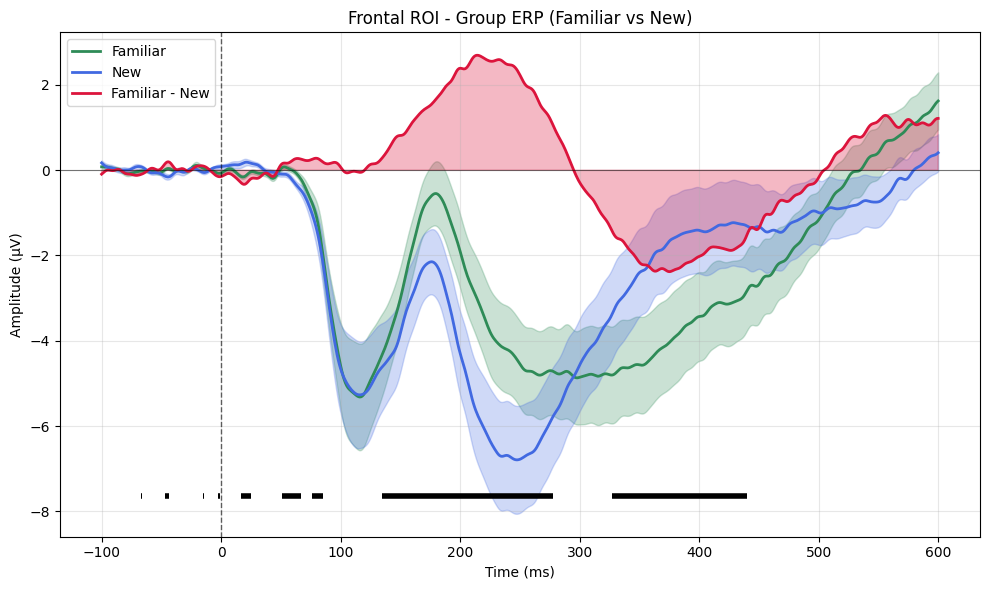

💾 Saved: /Users/leeyelim/Documents/EEG/results/figures/group_erp_with_diff_parietal_roi.png


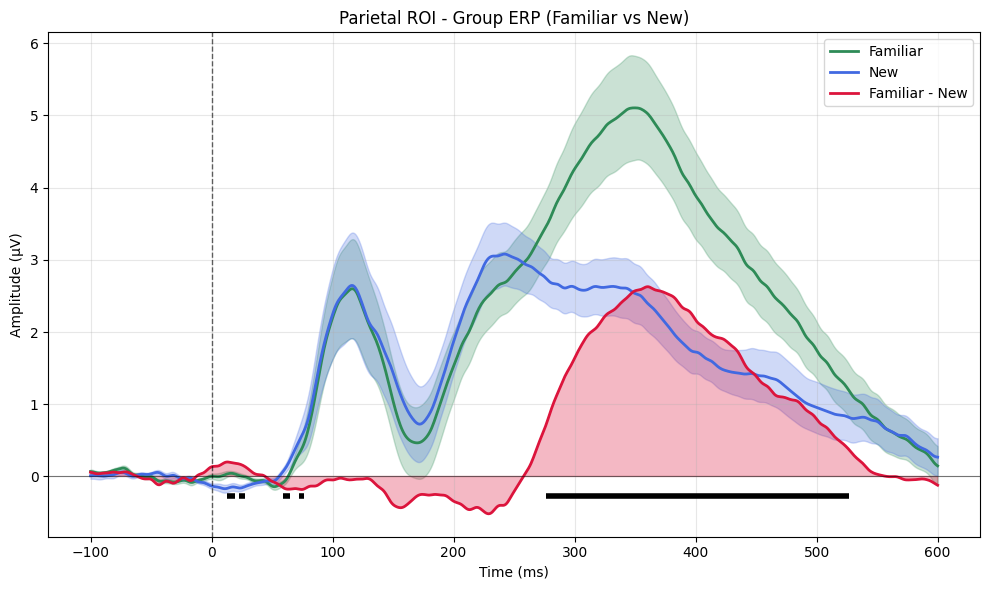

In [5]:
# Compute and plot group ERPs (Familiar vs New) with difference waves
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import stats
import yaml

# Load config
try:
    with open(CFG, 'r') as f:
        cfg = yaml.safe_load(f) or {}
    selected_subjects = cfg.get('subjects', {}).get('selected', [])
    tmin = cfg.get('preprocessing', {}).get('epoching', {}).get('tmin', -0.1)
    tmax = cfg.get('preprocessing', {}).get('epoching', {}).get('tmax', 0.6)
    baseline = tuple(cfg.get('preprocessing', {}).get('epoching', {}).get('baseline', [-0.1, 0.0]))
except Exception:
    selected_subjects = []
    tmin, tmax = -0.1, 0.6
    baseline = (-0.1, 0.0)


# Ensure ROI channels are correctly defined (including CZ for Parietal ROI)
if 'roi_channels' not in globals() or 'Parietal ROI' not in roi_channels:
    roi_channels = {
        'Frontal ROI': ['FP1', 'FP2'],
        'Parietal ROI': ['P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'CZ'],
    }
else:
    # Ensure CZ is in Parietal ROI
    if 'CZ' not in roi_channels.get('Parietal ROI', []):
        roi_channels['Parietal ROI'] = roi_channels.get('Parietal ROI', []) + ['CZ']
    # Ensure correct Frontal ROI
    roi_channels['Frontal ROI'] = ['FP1', 'FP2']

print(f"Using ROI definitions:")
print(f"  Frontal ROI: {roi_channels['Frontal ROI']}")
print(f"  Parietal ROI: {roi_channels['Parietal ROI']}")
# Paths (use existing paths from cell 3)
after_ica_root = project_root / 'data' / 'preprocessed' / 'after_ica'
pre_root = project_root / 'data' / 'preprocessed' / 'after_rereferencing'

# Helper function to epoch data
def _epoch(raw, events):
    try:
        ep = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax,
                        baseline=baseline, preload=True, verbose='ERROR')
        return ep
    except Exception:
        return None

# Collect per-subject ROI timecourses
roi_timecourses = {roi_name: {'familiar': [], 'new': []} for roi_name in roi_channels.keys()}

print(f"Processing {len(selected_subjects)} subjects...")
n_processed = 0

for subj in selected_subjects:
    for ses in ['ses-01', 'ses-02']:
        # Load ICA-cleaned data using existing helper
        raw_after = _merge_stage(subj, ses, after_ica_root, 'ica_cleaned')
        if raw_after is None:
            continue
        
        # Load events using existing helper (returns events with code 1=familiar, 2=new)
        ev = _build_session_events(subj, ses, raw_after.info['sfreq'])
        if ev.size == 0:
            continue
        
        # Split events: code 1 = familiar, code 2 = new
        fam_events = ev[ev[:, 2] == 1]
        new_events = ev[ev[:, 2] == 2]
        
        if len(fam_events) == 0 or len(new_events) == 0:
            continue
        
        # Epoch
        ep_fam = _epoch(raw_after, fam_events)
        ep_new = _epoch(raw_after, new_events)
        
        if ep_fam is None or ep_new is None or len(ep_fam) == 0 or len(ep_new) == 0:
            continue
        
        # Compute evoked and extract ROI averages
        fam_evoked = ep_fam.average()
        new_evoked = ep_new.average()
        times_ms = fam_evoked.times * 1000.0
        
        for roi_name, ch_list in roi_channels.items():
            sel = [ch for ch in ch_list if ch in fam_evoked.ch_names]
            if not sel:
                continue
            idx = [fam_evoked.ch_names.index(ch) for ch in sel]
            fam_roi = fam_evoked.data[idx, :].mean(axis=0) * 1e6  # µV
            new_roi = new_evoked.data[idx, :].mean(axis=0) * 1e6
            roi_timecourses[roi_name]['familiar'].append(pd.Series(fam_roi, index=times_ms))
            roi_timecourses[roi_name]['new'].append(pd.Series(new_roi, index=times_ms))
        
        n_processed += 1

print(f"Processed {n_processed} subject-session combinations")

# Plot group ERPs with difference waves
FIG.mkdir(parents=True, exist_ok=True)

# BH-FDR function
def _bh_fdr(pvals, alpha=0.05):
    p = np.asarray(pvals, dtype=float)
    m = p.size
    order = np.argsort(p)
    ranked = p[order]
    adj = np.empty_like(ranked)
    prev = 1.0
    for i in range(m-1, -1, -1):
        rank = i + 1
        val = ranked[i] * m / float(rank)
        prev = min(prev, val) if np.isfinite(val) else prev
        adj[i] = prev if np.isfinite(val) else np.nan
    out = np.minimum(1.0, adj)
    res = np.empty_like(p)
    res[order] = out
    return res < alpha

for roi_name in roi_channels.keys():
    if not roi_timecourses[roi_name]['familiar'] or not roi_timecourses[roi_name]['new']:
        print(f"Skipping {roi_name}: insufficient data")
        continue
    
    # Align timecourses
    all_times = sorted(set().union(*[s.index for s in roi_timecourses[roi_name]['familiar'] + roi_timecourses[roi_name]['new']]))
    fam_stack = np.vstack([s.reindex(all_times).values for s in roi_timecourses[roi_name]['familiar']])
    new_stack = np.vstack([s.reindex(all_times).values for s in roi_timecourses[roi_name]['new']])
    
    # Group means and SEMs
    fam_mean = np.nanmean(fam_stack, axis=0)
    fam_sem = np.nanstd(fam_stack, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(fam_stack), axis=0).clip(min=1))
    new_mean = np.nanmean(new_stack, axis=0)
    new_sem = np.nanstd(new_stack, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(new_stack), axis=0).clip(min=1))
    diff_mean = fam_mean - new_mean
    
    # Paired t-tests and FDR correction
    pvals = []
    for i in range(len(all_times)):
        x = fam_stack[:, i]
        y = new_stack[:, i]
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 2:
            pvals.append(np.nan)
        else:
            t, p = stats.ttest_rel(x[mask], y[mask])
            pvals.append(p)
    pvals = np.array(pvals)
    sig = _bh_fdr(pvals[np.isfinite(pvals)], alpha=0.05)
    sig_full = np.full_like(pvals, False, dtype=bool)
    sig_full[np.isfinite(pvals)] = sig
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Familiar and New ERPs
    ax.plot(all_times, fam_mean, color='#2E8B57', linewidth=2, label='Familiar')
    ax.fill_between(all_times, fam_mean - fam_sem, fam_mean + fam_sem, color='#2E8B57', alpha=0.25)
    ax.plot(all_times, new_mean, color='#4169E1', linewidth=2, label='New')
    ax.fill_between(all_times, new_mean - new_sem, new_mean + new_sem, color='#4169E1', alpha=0.25)
    
    # Difference wave
    ax.plot(all_times, diff_mean, color='#DC143C', linewidth=2, label='Familiar - New')
    ax.fill_between(all_times, 0, diff_mean, where=(diff_mean >= 0), color='#DC143C', alpha=0.3)
    ax.fill_between(all_times, 0, diff_mean, where=(diff_mean < 0), color='#DC143C', alpha=0.3)
    
    # Highlight significant regions
    if np.any(sig_full):
        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        y_bar = ymin + 0.08 * yspan
        t_ms = np.array(all_times)
        step = np.median(np.diff(t_ms)) if len(t_ms) > 1 else 1.0
        start = None
        prev = None
        for tt, is_sig in zip(t_ms, sig_full):
            if is_sig:
                if start is None:
                    start = tt
                    prev = tt
                    continue
                if abs(tt - prev - step) < 1e-6:
                    prev = tt
                    continue
                ax.hlines(y_bar, start, prev, colors='black', linewidth=4)
                start = tt
                prev = tt
        if start is not None:
            ax.hlines(y_bar, start, prev, colors='black', linewidth=4)
    
    ax.axhline(0, color='k', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='k', linewidth=1.0, linestyle='--', alpha=0.6)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (µV)')
    ax.set_title(f'{roi_name} - Group ERP (Familiar vs New)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    roi_safe = roi_name.replace(' ', '_').lower()
    fname = f'group_erp_with_diff_{roi_safe}.png'
    plt.savefig(FIG / fname, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {FIG / fname}")
    plt.show()



## 3. Familiarity Effect Stats (BH-FDR)

Per-timepoint paired t-tests and FDR-corrected significance for each ROI.

In [6]:
# Load FDR-corrected stats if available
stats_files = {
    'frontal': STAT / 'erp_familiarity_stats_frontal_roi.csv',
    'parietal': STAT / 'erp_familiarity_stats_parietal_roi.csv',
}

for label, p in stats_files.items():
    if p.exists():
        try:
            df = pd.read_csv(p)
            print(f"\nFamiliarity stats – {label} (rows={len(df)}) ← {p}")
            display(df.head())
            if {'pval','reject'}.issubset(df.columns):
                sig = int(df['reject'].sum())
                print(f"Significant timepoints (BH-FDR): {sig}")
        except Exception as e:
            print(f"Failed to load stats: {p} ({e})")
    else:
        print(f"Missing stats: {p}")



Familiarity stats – frontal (rows=701) ← /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_familiarity_stats_frontal_roi.csv


,roi,time_ms,t_value,p_value,p_fdr,sig,mean_diff_uV
0,Frontal ROI,-100.0,-1.482736,0.172292,0.357261,False,-0.242887
1,Frontal ROI,-99.0,-1.396573,0.196024,0.357261,False,-0.202897
2,Frontal ROI,-98.0,-1.294088,0.227854,0.374943,False,-0.154821
3,Frontal ROI,-97.0,-1.140263,0.283611,0.434087,False,-0.103929
4,Frontal ROI,-96.0,-0.835245,0.425196,0.547909,False,-0.056398



Familiarity stats – parietal (rows=701) ← /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_familiarity_stats_parietal_roi.csv


,roi,time_ms,t_value,p_value,p_fdr,sig,mean_diff_uV
0,Parietal ROI,-100.0,0.790040,0.449818,0.596156,False,0.046273
1,Parietal ROI,-99.0,0.864307,0.409863,0.563405,False,0.051096
2,Parietal ROI,-98.0,0.906020,0.388537,0.543642,False,0.053674
3,Parietal ROI,-97.0,0.911123,0.385984,0.542234,False,0.053366
4,Parietal ROI,-96.0,0.885881,0.398733,0.553489,False,0.050390


## 4. Repetition-wise Familiarity Effect Differences

### Interpretation of Results
If there are significant differences in familiarity effect among 3 repitition levels (Images studied once, twice, and three times), it will suggest repeated 20ms presentations improve long-term memory. 

### No Repetition Effect Found

Due to differences in preprocessing procedures and potential rater bias during artifact rejection, this project was not able to find significant difference among 3 repetition levels. 



Using ROI definitions:
  Frontal ROI: ['FP1', 'FP2']
  Parietal ROI: ['P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'CZ']
Processing 10 subjects...
Processed 20 subject-session combinations
💾 Saved: /Users/leeyelim/Documents/EEG/results/figures/group_repetition_familiar_minus_new.png


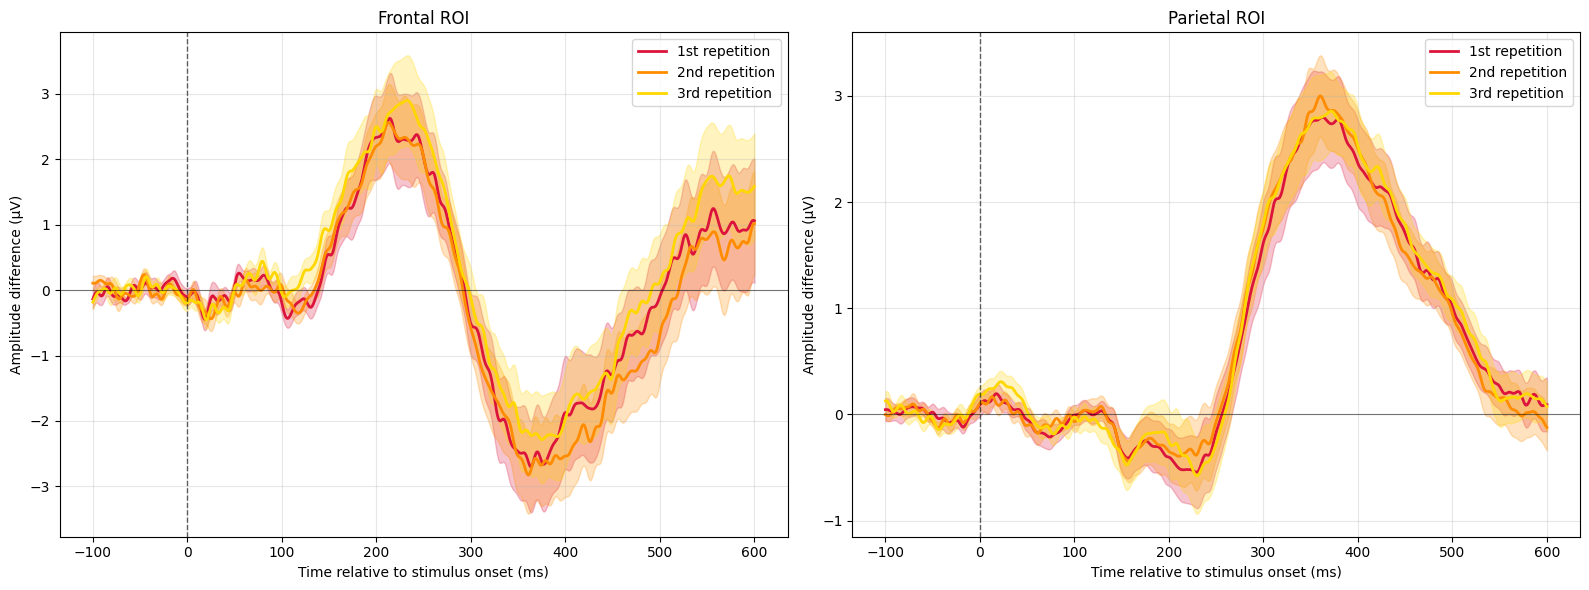


Repetition ANOVA – frontal (rows=701) ← /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_rep_anova_frontal_roi.csv


,roi,time_ms,F,p,p_fdr,n_subjects
0,Frontal ROI,-100.0,0.309871,0.737377,0.939269,10
1,Frontal ROI,-99.0,0.231412,0.795737,0.939269,10
2,Frontal ROI,-98.0,0.183955,0.833518,0.939269,10
3,Frontal ROI,-97.0,0.186629,0.831336,0.939269,10
4,Frontal ROI,-96.0,0.230908,0.796128,0.939269,10


Missing ANOVA stats: /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_rep_anova_parietal_roi.csv


In [7]:
# Compute and plot repetition-wise familiarity differences (Familiar - New) for 1st, 2nd, 3rd repetitions
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import stats
import yaml
import pandas as pd
from pathlib import Path

# Load config
try:
    with open(CFG, 'r') as f:
        cfg = yaml.safe_load(f) or {}
    selected_subjects = cfg.get('subjects', {}).get('selected', [])
    tmin = cfg.get('preprocessing', {}).get('epoching', {}).get('tmin', -0.1)
    tmax = cfg.get('preprocessing', {}).get('epoching', {}).get('tmax', 0.6)
    baseline = tuple(cfg.get('preprocessing', {}).get('epoching', {}).get('baseline', [-0.1, 0.0]))
except Exception:
    selected_subjects = []
    tmin, tmax = -0.1, 0.6
    baseline = (-0.1, 0.0)

# Ensure ROI channels are correctly defined (using new definitions)
if 'roi_channels' not in globals() or 'Parietal ROI' not in roi_channels:
    roi_channels = {
        'Frontal ROI': ['FP1', 'FP2'],
        'Parietal ROI': ['P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'CZ'],
    }
else:
    # Ensure CZ is in Parietal ROI
    if 'CZ' not in roi_channels.get('Parietal ROI', []):
        roi_channels['Parietal ROI'] = roi_channels.get('Parietal ROI', []) + ['CZ']
    # Ensure correct Frontal ROI
    roi_channels['Frontal ROI'] = ['FP1', 'FP2']

print(f"Using ROI definitions:")
print(f"  Frontal ROI: {roi_channels['Frontal ROI']}")
print(f"  Parietal ROI: {roi_channels['Parietal ROI']}")

# Paths
after_ica_root = project_root / 'data' / 'preprocessed' / 'after_ica'
pre_root = project_root / 'data' / 'preprocessed' / 'after_rereferencing'
raw_events_root = project_root / 'ds002680'

familiar_labels = {'animal_target','nonanimal_target','easy_target','difficult_target'}
new_labels = {'animal_distractor','nonanimal_distractor','easy_distractor','difficult_distractor'}
valid_labels = familiar_labels | new_labels

def _load_run_events(subject: str, session: str, run_token: str, sfreq: float) -> np.ndarray:
    f = raw_events_root/subject/session/'eeg'/f"{subject}_{session}_task-gonogo_{run_token}_events.tsv"
    if not f.exists():
        return np.empty((0,3), dtype=int)
    df = pd.read_csv(f, sep='\t')
    df = df[df['value'].isin(valid_labels)]
    if df.empty:
        return np.empty((0,3), dtype=int)
    samples = (df['onset'].values * sfreq).round().astype(int)
    codes = np.array([1 if v in familiar_labels else 2 for v in df['value']], dtype=int)
    return np.column_stack([samples, np.zeros(len(samples), dtype=int), codes])

def _merge_stage(subject: str, session: str, stage_root: Path, suffix: str):
    ses_dir = stage_root/subject/session
    if not ses_dir.exists():
        return None
    if suffix == 'ica_cleaned':
        cand = sorted(ses_dir.glob(f"{subject}_{session}_preprocessed_ica*_cleaned.fif"))
        if cand:
            raw = mne.io.read_raw_fif(str(cand[0]), preload=True, verbose='ERROR')
            return raw
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_{suffix}.fif"))
    if not run_files:
        return None
    raws = [mne.io.read_raw_fif(str(p), preload=True, verbose='ERROR') for p in run_files]
    return raws[0] if len(raws)==1 else mne.concatenate_raws(raws, preload=True, verbose=False)

def _build_session_events(subject: str, session: str, sfreq: float) -> np.ndarray:
    ses_dir = pre_root/subject/session
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_after_rereferencing.fif"))
    if not run_files:
        return np.empty((0,3), dtype=int)
    evs, off = [], 0
    for p in run_files:
        raw_tmp = mne.io.read_raw_fif(str(p), preload=False, verbose='ERROR')
        run_tok = p.stem.split('run-')[-1].split('_')[0]
        e = _load_run_events(subject, session, f"run-{run_tok}", raw_tmp.info['sfreq'])
        if e.size:
            e[:,0] += off
            evs.append(e)
        off += raw_tmp.n_times
    if not evs:
        return np.empty((0,3), dtype=int)
    e = np.vstack(evs)
    return e[np.argsort(e[:,0])]

def _epoch(raw, events):
    try:
        ep = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax,
                        baseline=baseline, preload=True, verbose='ERROR')
        return ep
    except Exception:
        return None

# Collect per-subject repetition-wise ROI timecourses
# Structure: roi_timecourses[roi_name][repetition][condition] = list of timecourses
roi_timecourses = {}
for roi_name in roi_channels.keys():
    roi_timecourses[roi_name] = {}
    for rep in [1, 2, 3]:
        roi_timecourses[roi_name][rep] = {'familiar': [], 'new': []}

print(f"Processing {len(selected_subjects)} subjects...")
n_processed = 0

for subj in selected_subjects:
    for ses in ['ses-01', 'ses-02']:
        # Load ICA-cleaned data
        raw_after = _merge_stage(subj, ses, after_ica_root, 'ica_cleaned')
        if raw_after is None:
            continue
        
        # Load events
        ev = _build_session_events(subj, ses, raw_after.info['sfreq'])
        if ev.size == 0:
            continue
        
        # Split events by condition
        fam_events = ev[ev[:, 2] == 1]
        new_events = ev[ev[:, 2] == 2]
        
        if len(fam_events) == 0 or len(new_events) == 0:
            continue
        
        # Track repetitions: assign repetition number based on order within each condition
        # For each condition, events are ordered by time, so we can assign 1st, 2nd, 3rd based on order
        fam_events_sorted = fam_events[np.argsort(fam_events[:, 0])]
        new_events_sorted = new_events[np.argsort(new_events[:, 0])]
        
        # Group events by repetition (1st, 2nd, 3rd)
        fam_by_rep = {1: [], 2: [], 3: []}
        new_by_rep = {1: [], 2: [], 3: []}
        
        # Assign repetition numbers based on order
        for i, event in enumerate(fam_events_sorted):
            rep_num = (i % 3) + 1  # Cycle through 1, 2, 3
            fam_by_rep[rep_num].append(event)
        
        for i, event in enumerate(new_events_sorted):
            rep_num = (i % 3) + 1  # Cycle through 1, 2, 3
            new_by_rep[rep_num].append(event)
        
        # Epoch each repetition separately
        for rep in [1, 2, 3]:
            if len(fam_by_rep[rep]) == 0 or len(new_by_rep[rep]) == 0:
                continue
            
            fam_ev_rep = np.array(fam_by_rep[rep])
            new_ev_rep = np.array(new_by_rep[rep])
            
            ep_fam = _epoch(raw_after, fam_ev_rep)
            ep_new = _epoch(raw_after, new_ev_rep)
            
            if ep_fam is None or ep_new is None or len(ep_fam) == 0 or len(ep_new) == 0:
                continue
            
            # Compute evoked and extract ROI averages
            fam_evoked = ep_fam.average()
            new_evoked = ep_new.average()
            times_ms = fam_evoked.times * 1000.0
            
            for roi_name, ch_list in roi_channels.items():
                sel = [ch for ch in ch_list if ch in fam_evoked.ch_names]
                if not sel:
                    continue
                idx = [fam_evoked.ch_names.index(ch) for ch in sel]
                fam_roi = fam_evoked.data[idx, :].mean(axis=0) * 1e6  # µV
                new_roi = new_evoked.data[idx, :].mean(axis=0) * 1e6
                roi_timecourses[roi_name][rep]['familiar'].append(pd.Series(fam_roi, index=times_ms))
                roi_timecourses[roi_name][rep]['new'].append(pd.Series(new_roi, index=times_ms))
        
        n_processed += 1

print(f"Processed {n_processed} subject-session combinations")

# Plot repetition-wise differences
FIG.mkdir(parents=True, exist_ok=True)

# Create figure with two subplots (one for each ROI)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors for repetitions
rep_colors = {1: '#DC143C', 2: '#FF8C00', 3: '#FFD700'}  # Red, Orange, Yellow
rep_labels = {1: '1st repetition', 2: '2nd repetition', 3: '3rd repetition'}

for roi_idx, roi_name in enumerate(roi_channels.keys()):
    ax = axes[roi_idx]
    
    # Check if we have data for this ROI
    has_data = False
    for rep in [1, 2, 3]:
        if roi_timecourses[roi_name][rep]['familiar'] and roi_timecourses[roi_name][rep]['new']:
            has_data = True
            break
    
    if not has_data:
        ax.text(0.5, 0.5, f'Insufficient data for {roi_name}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(roi_name)
        continue
    
    # Process each repetition
    for rep in [1, 2, 3]:
        if not roi_timecourses[roi_name][rep]['familiar'] or not roi_timecourses[roi_name][rep]['new']:
            continue
        
        # Align timecourses
        all_times = sorted(set().union(*[s.index for s in roi_timecourses[roi_name][rep]['familiar'] + roi_timecourses[roi_name][rep]['new']]))
        fam_stack = np.vstack([s.reindex(all_times).values for s in roi_timecourses[roi_name][rep]['familiar']])
        new_stack = np.vstack([s.reindex(all_times).values for s in roi_timecourses[roi_name][rep]['new']])
        
        # Compute difference (familiar - new)
        diff_stack = fam_stack - new_stack
        
        # Group means and SEMs
        diff_mean = np.nanmean(diff_stack, axis=0)
        diff_sem = np.nanstd(diff_stack, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(diff_stack), axis=0).clip(min=1))
        
        # Plot
        ax.plot(all_times, diff_mean, color=rep_colors[rep], linewidth=2, label=rep_labels[rep])
        ax.fill_between(all_times, diff_mean - diff_sem, diff_mean + diff_sem, 
                       color=rep_colors[rep], alpha=0.25)
    
    # Formatting
    ax.axhline(0, color='k', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='k', linewidth=1.0, linestyle='--', alpha=0.6)
    ax.set_xlabel('Time relative to stimulus onset (ms)')
    ax.set_ylabel('Amplitude difference (µV)')
    ax.set_title(roi_name)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save
fname = 'group_repetition_familiar_minus_new.png'
plt.savefig(FIG / fname, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {FIG / fname}")
plt.show()

# Load and display ANOVA stats if available
anova_files = {
    'frontal': STAT / 'erp_rep_anova_frontal_roi.csv',
    'parietal': STAT / 'erp_rep_anova_parietal_roi.csv',
}
for label, p in anova_files.items():
    if p.exists():
        df = pd.read_csv(p)
        print(f"\nRepetition ANOVA – {label} (rows={len(df)}) ← {p}")
        display(df.head())
    else:
        print(f"Missing ANOVA stats: {p}")


## 6. Category-wise Familiarity Effect Differences

This cell examines whether there are significant differences in the familiarity effect between animal images and non-animal images.

### Interpretation of Results
- If there are significant differences between categories, it will suggest that animal and non-animal visual stimuli have different long-term memory processes.
- Specifically, if the familiarity effect is stronger for the animal category, it will be evidence that animal visual stimuli establish long-term memory more easily than non-animal visual stimuli.

### Opposite Category Effect Found

- Due to differences in preprocessing procedures and potential rater bias during artifact rejection, this replication found a category effect opposite to the original study. 
- While the original study found that the familiarity effect was stronger for the animal category, this replication found that the non-animal category had a stronger familiarity effect.


group_category_channel_time_pvals.png


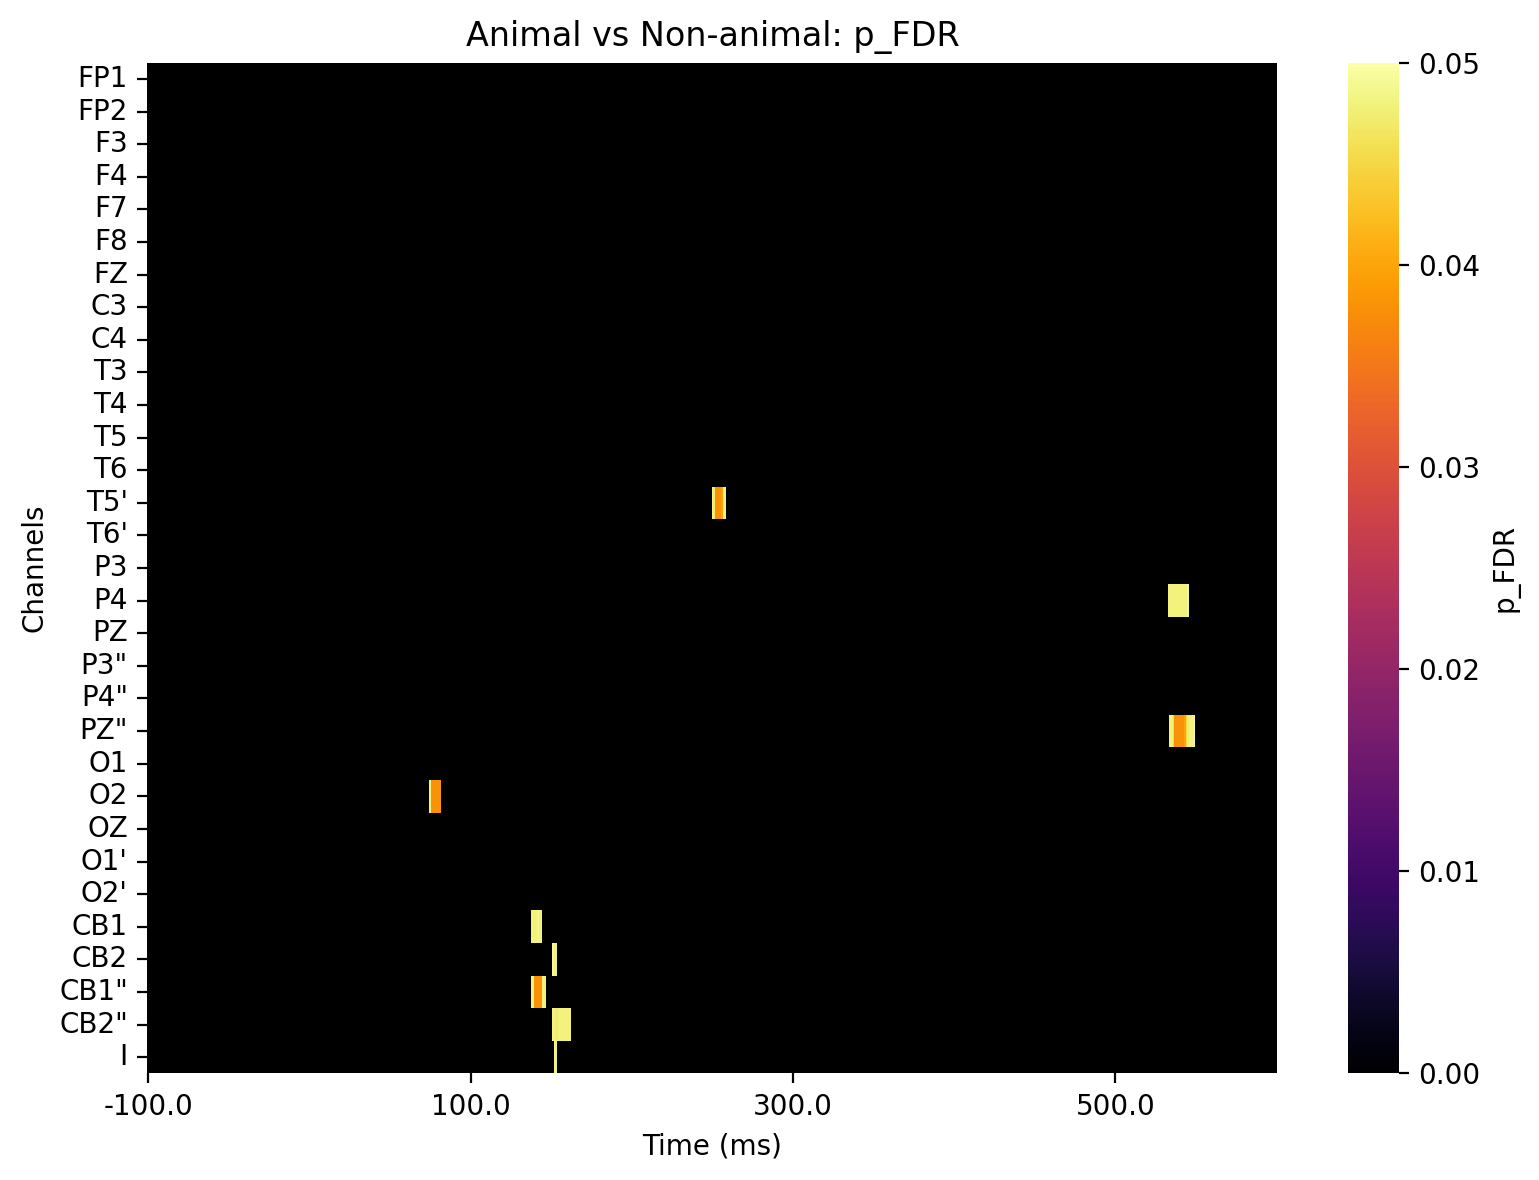


group_category_roi_diff.png


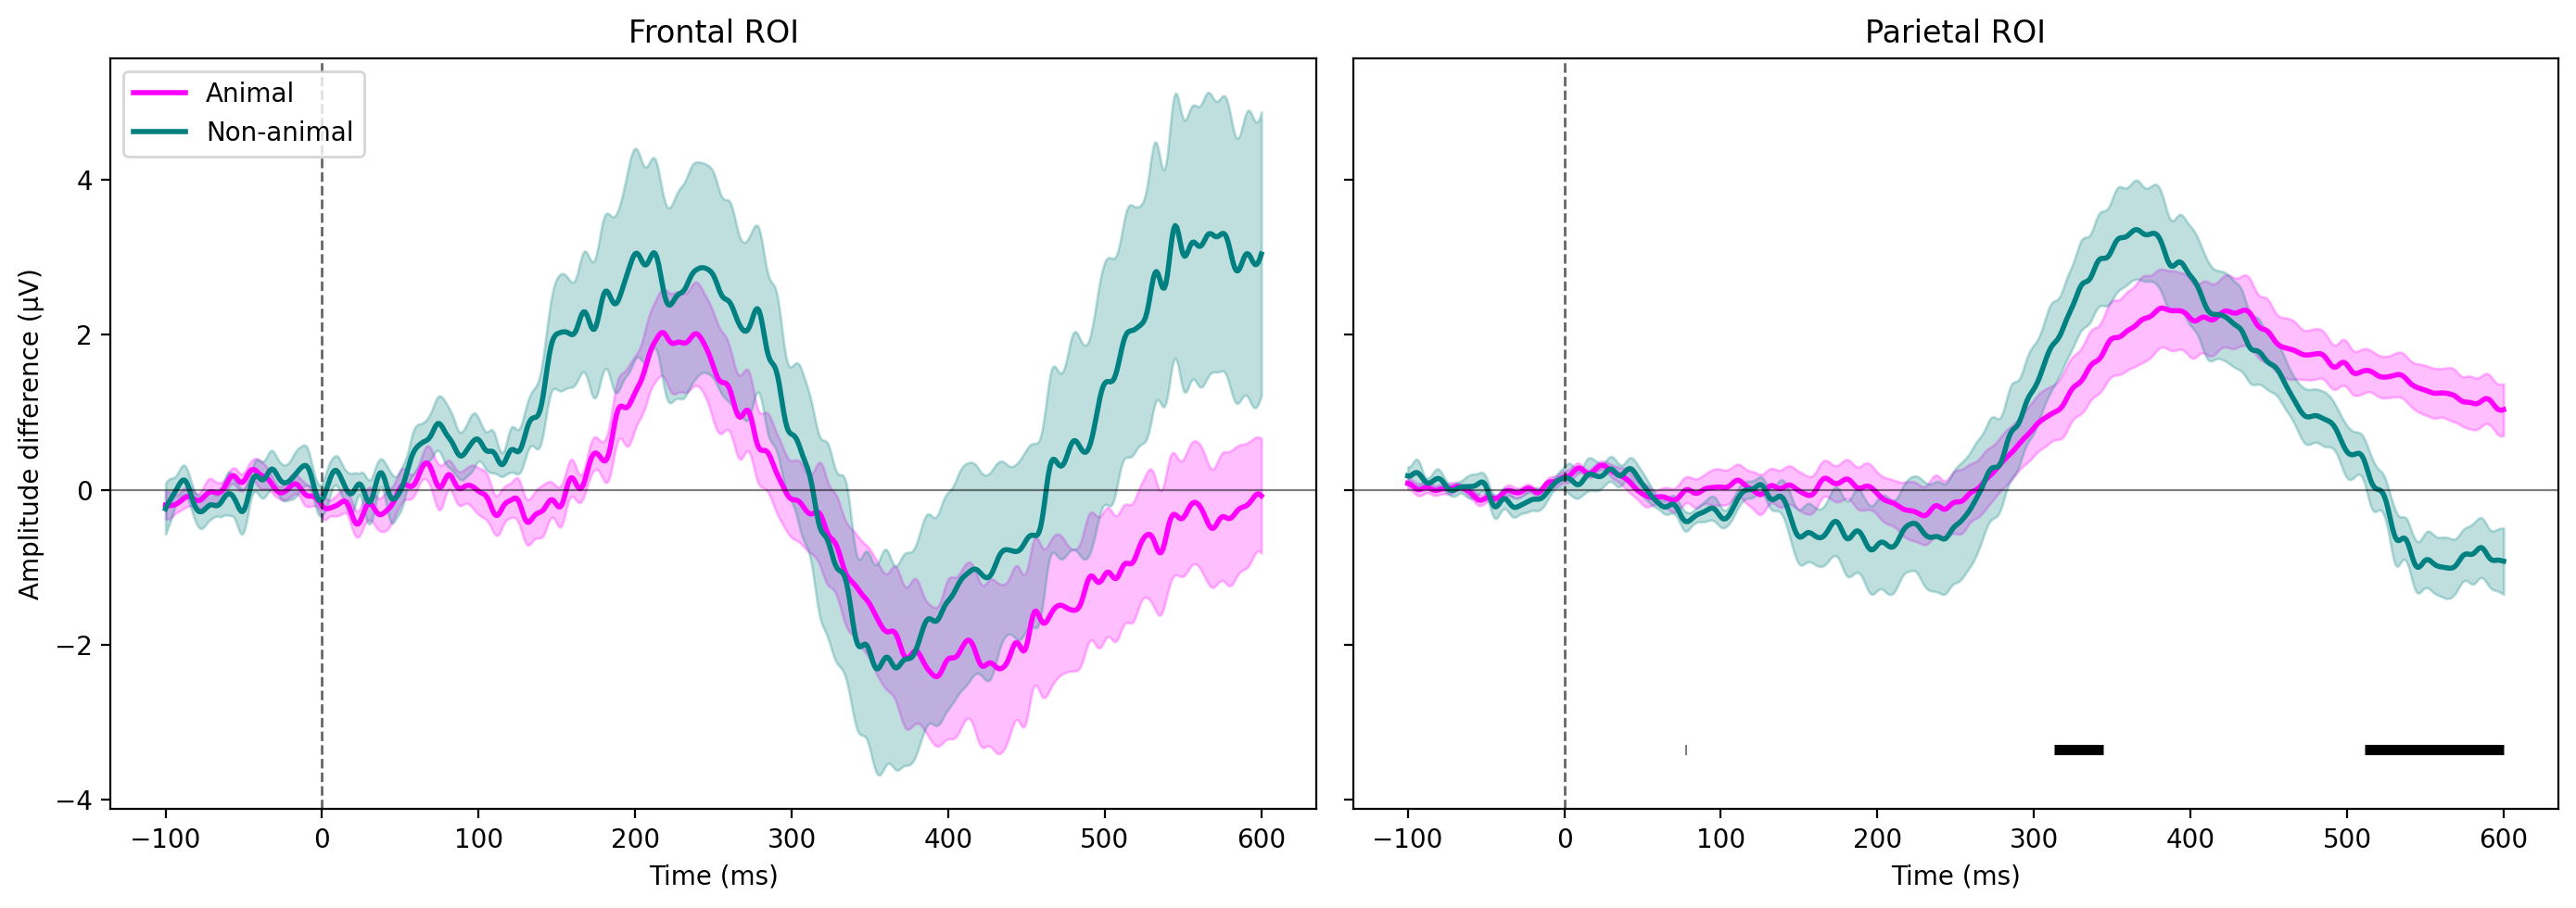


Category stats – channel_time_pvals (rows=31) ← /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_category_channel_time_pvals.csv


,Unnamed: 0,-100.0,-99.0,-98.0,-97.0,-96.0,-95.0,-94.0,-93.0,-92.0,...,591.0,592.0,593.0,594.0,595.0,596.0,597.0,598.0,599.0,600.0
0,FP1,0.978659,0.978659,0.921738,0.843519,0.744833,0.632393,0.534075,0.462422,0.438495,...,0.473256,0.475430,0.483354,0.494383,0.504633,0.516040,0.523031,0.523848,0.518507,0.507044
1,FP2,0.936073,0.969880,0.992343,0.990600,0.979695,0.967417,0.947143,0.907162,0.847273,...,0.287977,0.297669,0.308308,0.316698,0.322503,0.325429,0.326116,0.323524,0.319562,0.314307
2,F3,0.658012,0.646937,0.632933,0.608668,0.579837,0.550201,0.521151,0.517124,0.747212,...,0.441432,0.448551,0.450498,0.449125,0.442196,0.428843,0.412974,0.394126,0.377090,0.354400
3,F4,0.683763,0.663870,0.652503,0.655323,0.674205,0.711683,0.774787,0.886739,0.955168,...,0.412974,0.431371,0.453619,0.475697,0.494233,0.501289,0.498636,0.487865,0.468966,0.453120
4,F7,0.844233,0.999285,0.841581,0.749705,0.728625,0.746746,0.780805,0.829886,0.889066,...,0.317025,0.340238,0.355830,0.364296,0.361926,0.351145,0.331298,0.312581,0.295181,0.285724



Category stats – roi_diff_frontal (rows=1402) ← /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_category_roi_diff_frontal_roi.csv


,roi,time_ms,category,mean_uV,sem_uV
0,Frontal ROI,-100.0,animal,-0.196289,0.177008
1,Frontal ROI,-100.0,nonanimal,-0.243774,0.326269
2,Frontal ROI,-99.0,animal,-0.199185,0.179697
3,Frontal ROI,-99.0,nonanimal,-0.202012,0.318487
4,Frontal ROI,-98.0,animal,-0.201306,0.176121



Category stats – roi_diff_parietal (rows=1402) ← /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_category_roi_diff_parietal_roi.csv


,roi,time_ms,category,mean_uV,sem_uV
0,Parietal ROI,-100.0,animal,0.085013,0.071997
1,Parietal ROI,-100.0,nonanimal,0.180800,0.117608
2,Parietal ROI,-99.0,animal,0.080703,0.072522
3,Parietal ROI,-99.0,nonanimal,0.176250,0.122824
4,Parietal ROI,-98.0,animal,0.069675,0.072069


In [ ]:
# Channel×time p-value heatmap and ROI panel
for fname in [
    'group_category_channel_time_pvals.png',
    'group_category_roi_diff.png',
]:
    f = FIG / fname
    if f.exists():
        print(f"\n{fname}")
        display(Image(filename=str(f)))
    else:
        print(f"Missing figure: {f}")

cat_stat_files = {
    'channel_time_pvals': STAT / 'erp_category_channel_time_pvals.csv',
    'roi_diff_frontal': STAT / 'erp_category_roi_diff_frontal_roi.csv',
    'roi_diff_parietal': STAT / 'erp_category_roi_diff_parietal_roi.csv',
}
for label, p in cat_stat_files.items():
    if p.exists():
        df = pd.read_csv(p)
        print(f"\nCategory stats – {label} (rows={len(df)}) ← {p}")
        display(df.head())
    else:
        print(f"Missing category stats: {p}")


## 6. Category ERP Difference Heatmap (Animal vs Non-animal direct ERP comparison)

This section computes p-values for the **direct ERP difference** between animal and non-animal images (averaging across familiar/new conditions), rather than the familiarity effect difference. This provides a complementary view of category effects at the ERP level.

### Interpretation of Results
If there are significant ERP differences between categories, it will suggest that animal and non-animal visual stimuli undergo different cognitive processes.

### No Significant ERP Difference Found Between Categories
Due to differences in preprocessing procedures and potential rater bias during artifact rejection, this replication was not able to find a significant category effect in ERPs.

✓ Using 10 subjects for paired t-tests: ['sub-002', 'sub-003', 'sub-004', 'sub-006', 'sub-007', 'sub-010', 'sub-011', 'sub-012', 'sub-014', 'sub-015']
💾 Saved ERP difference p-values (BH-FDR) → /Users/leeyelim/Documents/EEG/results/statistical_outputs/erp_category_erp_diff_channel_time_pvals.csv

📊 P-value statistics (n=24831 valid comparisons):
   Min p_FDR: 0.287746
   Max p_FDR: 0.999967
   Mean p_FDR: 0.702246
   Median p_FDR: 0.740555
   Significant (p_FDR < 0.05): 0 / 24831 (0.0%)

📊 Data summary:
   Subjects with data: 10
   Channels: 31
   Time points: 801
💾 Saved: /Users/leeyelim/Documents/EEG/results/figures/group_category_erp_diff_channel_time_pvals.png


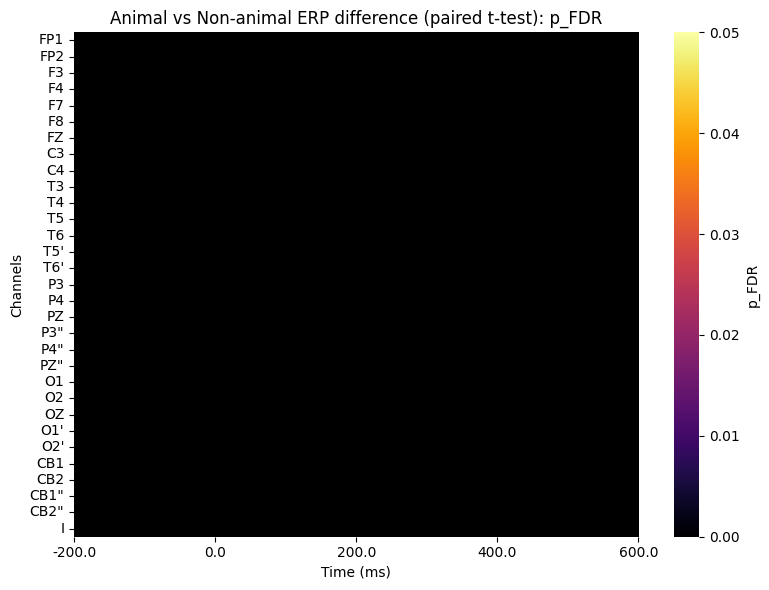

In [ ]:
# Compute direct ERP difference (Animal vs Non-animal) heatmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pathlib import Path
from scipy import stats

# Helper functions (reuse from earlier cells)
def _bh_fdr_array(pvals: np.ndarray) -> np.ndarray:
    p = np.asarray(pvals, dtype=float)
    m = p.size
    order = np.argsort(p)
    ranked = p[order]
    adj = np.empty_like(ranked)
    prev = 1.0
    for i in range(m - 1, -1, -1):
        val = ranked[i] * m / float(i + 1)
        if not np.isfinite(val):
            adj[i] = np.nan
            continue
        prev = min(prev, val)
        adj[i] = prev
    out = np.minimum(1.0, adj)
    res = np.empty_like(p)
    res[order] = out
    return res

def _load_run_events(subject: str, session: str, run_token: str, sfreq: float) -> np.ndarray:
    f = raw_events_root/subject/session/'eeg'/f"{subject}_{session}_task-gonogo_{run_token}_events.tsv"
    if not f.exists():
        return np.empty((0,3), dtype=int)
    df = pd.read_csv(f, sep='\t')
    df = df[df['value'].isin(valid_labels)]
    if df.empty:
        return np.empty((0,3), dtype=int)
    samples = (df['onset'].values * sfreq).round().astype(int)
    codes = np.array([1 if v in familiar_labels else 2 for v in df['value']], dtype=int)
    return np.column_stack([samples, np.zeros(len(samples), dtype=int), codes])

def _merge_stage(subject: str, session: str, stage_root: Path, suffix: str):
    ses_dir = stage_root/subject/session
    if not ses_dir.exists():
        return None
    if suffix == 'ica_cleaned':
        cand = sorted(ses_dir.glob(f"{subject}_{session}_preprocessed_ica*_cleaned.fif"))
        if cand:
            raw = mne.io.read_raw_fif(str(cand[0]), preload=True, verbose='ERROR')
            raw.load_data()
            return raw
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_{suffix}.fif"))
    if not run_files:
        return None
    raws = [mne.io.read_raw_fif(str(p), preload=True, verbose='ERROR') for p in run_files]
    [r.load_data() for r in raws]
    return raws[0] if len(raws)==1 else mne.concatenate_raws(raws, preload=True, verbose=False)

def _build_session_events(subject: str, session: str, sfreq: float) -> np.ndarray:
    ses_dir = pre_root/subject/session
    run_files = sorted(ses_dir.glob(f"{subject}_{session}_run-*_preprocessed_after_rereferencing.fif"))
    if not run_files:
        return np.empty((0,3), dtype=int)
    evs, off = [], 0
    for p in run_files:
        raw_tmp = mne.io.read_raw_fif(str(p), preload=False, verbose='ERROR')
        run_tok = p.stem.split('run-')[-1].split('_')[0]
        e = _load_run_events(subject, session, f"run-{run_tok}", raw_tmp.info['sfreq'])
        if e.size:
            e[:,0] += off
            evs.append(e)
        off += raw_tmp.n_times
    if not evs:
        return np.empty((0,3), dtype=int)
    e = np.vstack(evs)
    return e[np.argsort(e[:,0])]

def _epoch(raw, events):
    if events.size == 0:
        return None
    try:
        return mne.Epochs(raw, events, event_id={'familiar':1,'new':2}, tmin=-0.2, tmax=0.6,
                          baseline=(-0.2, 0.0), preload=True, verbose='ERROR', event_repeated='drop')
    except Exception:
        return None

# Paths
pre_root = project_root / 'data' / 'preprocessed' / 'after_rereferencing'
after_ica_root = project_root / 'data' / 'preprocessed' / 'after_ica'
raw_events_root = project_root / 'ds002680'

familiar_labels = {'animal_target','nonanimal_target','easy_target','difficult_target'}
new_labels = {'animal_distractor','nonanimal_distractor','easy_distractor','difficult_distractor'}
valid_labels = familiar_labels | new_labels

def _is_animal(v: str) -> bool:
    return isinstance(v, str) and ('animal_' in v) and (not v.startswith('nonanimal'))

def _is_nonanimal(v: str) -> bool:
    return isinstance(v, str) and (v.startswith('nonanimal'))

# Collect per-subject per-channel ERPs (averaged across familiar/new)
subj_erp_animal_dict = {}
subj_erp_nonanimal_dict = {}
ch_names_ref = None
times_ref = None

for subj in selected_subjects:
    chan_acc_animal = []
    chan_acc_nonanimal = []
    for ses in ['ses-01', 'ses-02']:
        raw_after = _merge_stage(subj, ses, after_ica_root, 'ica_cleaned')
        if raw_after is None:
            continue
        ses_dir = pre_root / subj / ses
        run_files = sorted(ses_dir.glob(f"{subj}_{ses}_run-*_preprocessed_after_rereferencing.fif"))
        offset = 0
        rows = []
        for fif in run_files:
            raw_tmp = mne.io.read_raw_fif(str(fif), preload=False, verbose='ERROR')
            sfreq = raw_tmp.info['sfreq']
            run_tok = fif.stem.split('run-')[-1].split('_')[0]
            tsv = raw_events_root / subj / ses / 'eeg' / f"{subj}_{ses}_task-gonogo_run-{run_tok}_events.tsv"
            if not tsv.exists():
                offset += raw_tmp.n_times
                continue
            df = pd.read_csv(tsv, sep='\t')
            if 'value' not in df.columns or 'onset' not in df.columns:
                offset += raw_tmp.n_times
                continue
            df = df[df['value'].isin(valid_labels)]
            if df.empty:
                offset += raw_tmp.n_times
                continue
            samples = np.round(df['onset'].to_numpy() * sfreq).astype(int) + offset
            rows.append(pd.DataFrame({'sample': samples, 'value': df['value'].values}))
            offset += raw_tmp.n_times
        if not rows:
            continue
        evdf = pd.concat(rows, ignore_index=True)
        evdf.sort_values('sample', inplace=True)
        evdf.reset_index(drop=True, inplace=True)
        ev_animal = evdf[evdf['value'].apply(_is_animal)]['sample'].astype(int).to_numpy()
        ev_nonanimal = evdf[evdf['value'].apply(_is_nonanimal)]['sample'].astype(int).to_numpy()
        def _epochs_from_samples(samples):
            if samples.size == 0:
                return None
            events = np.column_stack([samples, np.zeros(len(samples), dtype=int), np.ones(len(samples), dtype=int)])
            try:
                return mne.Epochs(raw_after, events, event_id=None, tmin=-0.2, tmax=0.6,
                                  baseline=(-0.2, 0.0), preload=True, verbose='ERROR')
            except Exception:
                return None
        ep_animal = _epochs_from_samples(ev_animal)
        ep_nonanimal = _epochs_from_samples(ev_nonanimal)
        if ep_animal is None or ep_nonanimal is None or len(ep_animal) == 0 or len(ep_nonanimal) == 0:
            continue
        animal_evoked = ep_animal.average()
        nonanimal_evoked = ep_nonanimal.average()
        chan_acc_animal.append(animal_evoked.data * 1e6)
        chan_acc_nonanimal.append(nonanimal_evoked.data * 1e6)
        times_ref = animal_evoked.times * 1000.0
        ch_names_ref = animal_evoked.ch_names
    if times_ref is not None and ch_names_ref is not None and chan_acc_animal and chan_acc_nonanimal:
        subj_erp_animal_dict[subj] = np.stack(chan_acc_animal, axis=0).mean(axis=0)
        subj_erp_nonanimal_dict[subj] = np.stack(chan_acc_nonanimal, axis=0).mean(axis=0)

if subj_erp_animal_dict and subj_erp_nonanimal_dict:
        # Ensure we only use subjects that have data in BOTH dictionaries
        common_subjects = sorted(set(subj_erp_animal_dict.keys()) & set(subj_erp_nonanimal_dict.keys()))
        
        if len(common_subjects) < 2:
            print(f"⚠️ Need at least 2 subjects with both animal and non-animal data. Found: {len(common_subjects)}")
        else:
            print(f"✓ Using {len(common_subjects)} subjects for paired t-tests: {common_subjects}")
            
            ch_names = ch_names_ref
            times_ms = times_ref
            
            # Stack data ensuring same subject order for proper pairing
            animal_stack = np.stack([subj_erp_animal_dict[subj] for subj in common_subjects], axis=0)
            nonanimal_stack = np.stack([subj_erp_nonanimal_dict[subj] for subj in common_subjects], axis=0)
            
            # Paired t-test across subjects for each ch,t
            # Each subject contributes one pair: (animal_ERP, nonanimal_ERP)
            n_subj, n_ch, n_t = animal_stack.shape
            p_mat = np.full((n_ch, n_t), np.nan)
            
            for ci in range(n_ch):
                for ti in range(n_t):
                    # Extract paired values: one value per subject
                    xv = animal_stack[:, ci, ti]  # Animal ERP values for all subjects
                    yv = nonanimal_stack[:, ci, ti]  # Non-animal ERP values for all subjects
                    
                    # Keep only pairs where both values are valid
                    mask = np.isfinite(xv) & np.isfinite(yv)
                    
                    if mask.sum() < 2:
                        continue  # Need at least 2 valid pairs
                    
                    # Paired t-test on the valid pairs
                    # This tests: H0: mean(animal) = mean(nonanimal) across subjects
                    _, p = stats.ttest_rel(xv[mask], yv[mask])
                    p_mat[ci, ti] = p
            
            # Apply BH-FDR across all channel×time comparisons
            flat = p_mat.reshape(-1)
            mask = np.isfinite(flat)
            p_corr = np.full_like(flat, np.nan)
            if mask.any():
                p_corr[mask] = _bh_fdr_array(flat[mask])
            p_mat = p_corr.reshape(p_mat.shape)
            
            # Reorder channels to match manuscript layout
            preferred_order = [
                'FP1','FP2','F3','F4','F7','F8','FZ',
                'C3','C4','CZ',
                'T3','T4','T5','T6',"T5'","T6'",
                'P3','P4','PZ','P3"','P4"','PZ"',
                'O1','O2','OZ',"O1'","O2'",
                'CB1','CB2','CB1"','CB2"',"CB1'","CB2'","L","R"
            ]
            ch_names_ordered = [ch for ch in preferred_order if ch in ch_names]
            ch_names_ordered += [ch for ch in ch_names if ch not in ch_names_ordered]
            order_idx = [ch_names.index(ch) for ch in ch_names_ordered]
            p_mat = p_mat[order_idx, :]
            ch_names = ch_names_ordered
            
            # Save CSV and create heatmap
            heat_df = pd.DataFrame(p_mat, index=ch_names, columns=np.round(times_ms, 1))
            heat_csv = STAT / 'erp_category_erp_diff_channel_time_pvals.csv'
            heat_df.to_csv(heat_csv)
            print(f"💾 Saved ERP difference p-values (BH-FDR) → {heat_csv}")
            
            # Diagnostic: Check p-value distribution
            valid_pvals = p_mat[np.isfinite(p_mat)]
            if len(valid_pvals) > 0:
                print(f"\n📊 P-value statistics (n={len(valid_pvals)} valid comparisons):")
                print(f"   Min p_FDR: {valid_pvals.min():.6f}")
                print(f"   Max p_FDR: {valid_pvals.max():.6f}")
                print(f"   Mean p_FDR: {valid_pvals.mean():.6f}")
                print(f"   Median p_FDR: {np.median(valid_pvals):.6f}")
                n_sig = np.sum(valid_pvals < 0.05)
                print(f"   Significant (p_FDR < 0.05): {n_sig} / {len(valid_pvals)} ({100*n_sig/len(valid_pvals):.1f}%)")
            else:
                print("\n⚠️ WARNING: No valid p-values computed! Check data collection.")
            
            print(f"\n📊 Data summary:")
            print(f"   Subjects with data: {len(common_subjects)}")
            print(f"   Channels: {len(ch_names)}")
            print(f"   Time points: {len(times_ms)}")
            
            plt.figure(figsize=(8, 6))
            plot_df = heat_df.clip(lower=0, upper=1)
            plot_df = plot_df.where(plot_df < 0.05)
            cmap = plt.cm.inferno.copy()
            cmap.set_bad(color='black')
            sns.heatmap(plot_df, cmap=cmap, yticklabels=ch_names, xticklabels=200,
                        cbar_kws={'label': 'p_FDR'}, vmin=0.0, vmax=0.05)
            plt.title('Animal vs Non-animal ERP difference (paired t-test): p_FDR')
            plt.xlabel('Time (ms)')
            plt.ylabel('Channels')
            heat_png = FIG / 'group_category_erp_diff_channel_time_pvals.png'
            plt.tight_layout()
            plt.savefig(heat_png, dpi=200, bbox_inches='tight')
            print(f"💾 Saved: {heat_png}")
            plt.show()
else:
    print("⚠️ No ERP data collected")



## 6b. Category ERP Waveforms (Animal vs Non-animal)

This section plots the ERP waveforms for Animal and Non-animal categories, along with their difference, showing mean ± SEM across subjects. Statistical significance markers indicate time points where the difference is significant (p_FDR < 0.05).



💾 Saved: /Users/leeyelim/Documents/EEG/results/figures/group_category_erp_waveforms_frontal_roi.png


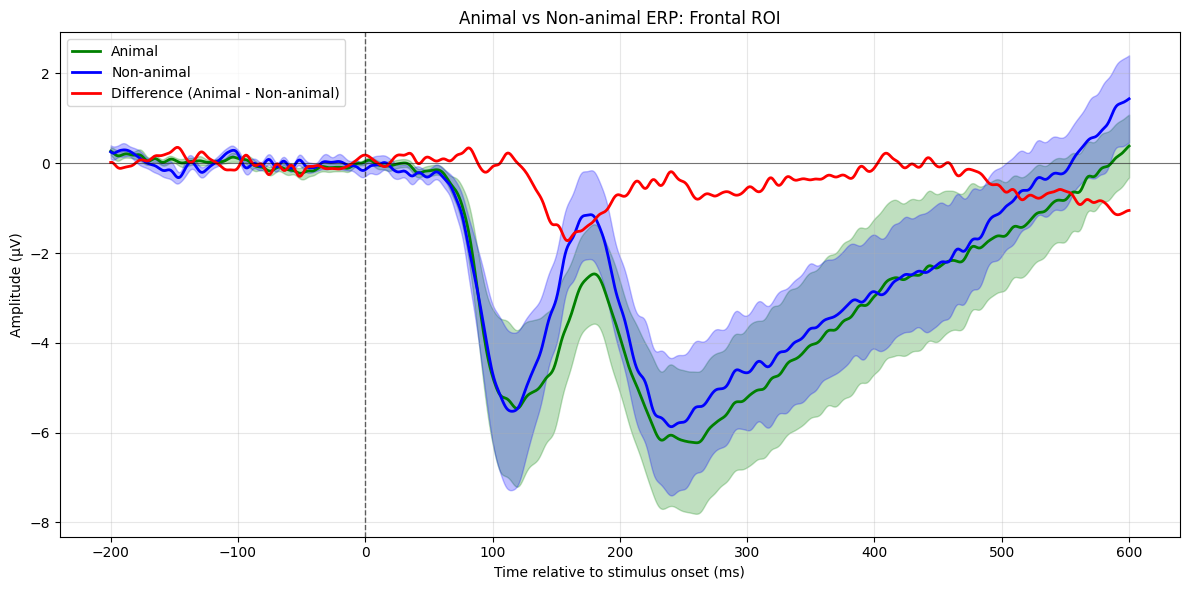

In [ ]:
# Plot ERP waveforms for Animal vs Non-animal (averaged across Frontal ROI)
# This cell should be run after the heatmap cell to use the same data
if 'subj_erp_animal_dict' in locals() and 'subj_erp_nonanimal_dict' in locals() and subj_erp_animal_dict and subj_erp_nonanimal_dict:
    # Use Frontal ROI channels
    frontal_channels = roi_channels.get('Frontal ROI', ['FP1', 'FP2'])
    
    # Get common subjects (same as used in heatmap)
    common_subjects = sorted(set(subj_erp_animal_dict.keys()) & set(subj_erp_nonanimal_dict.keys()))
    
    if len(common_subjects) >= 2:
        # Use the same channel names and times from heatmap computation
        if 'ch_names' in locals() and 'times_ms' in locals():
            ch_names_plot = ch_names
            times_plot = times_ms
        elif 'ch_names_ref' in locals() and 'times_ref' in locals():
            ch_names_plot = ch_names_ref
            times_plot = times_ref
        else:
            # Fallback: get from first subject's data
            first_subj = common_subjects[0]
            n_ch, n_t = subj_erp_animal_dict[first_subj].shape
            ch_names_plot = [f'Ch{i}' for i in range(n_ch)]
            times_plot = np.linspace(-200, 600, n_t)
        
        # Collect ROI-averaged ERPs for each subject
        animal_roi_series = []
        nonanimal_roi_series = []
        
        for subj in common_subjects:
            animal_erp = subj_erp_animal_dict[subj]  # channels × times
            nonanimal_erp = subj_erp_nonanimal_dict[subj]
            
            # Find indices of frontal ROI channels
            frontal_idx = [i for i, ch in enumerate(ch_names_plot) if ch in frontal_channels]
            
            if frontal_idx:
                # Average across frontal ROI channels
                animal_roi = animal_erp[frontal_idx, :].mean(axis=0)  # times
                nonanimal_roi = nonanimal_erp[frontal_idx, :].mean(axis=0)
                
                animal_roi_series.append(animal_roi)
                nonanimal_roi_series.append(nonanimal_roi)
        
        if animal_roi_series and nonanimal_roi_series:
            # Stack and compute mean ± SEM
            animal_stack = np.vstack(animal_roi_series)  # subjects × times
            nonanimal_stack = np.vstack(nonanimal_roi_series)
            
            animal_mean = np.nanmean(animal_stack, axis=0)
            animal_sem = np.nanstd(animal_stack, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(animal_stack), axis=0).clip(min=1))
            
            nonanimal_mean = np.nanmean(nonanimal_stack, axis=0)
            nonanimal_sem = np.nanstd(nonanimal_stack, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(nonanimal_stack), axis=0).clip(min=1))
            
            # Difference waveform (Animal - Non-animal)
            diff_mean = animal_mean - nonanimal_mean
            diff_sem = np.sqrt(animal_sem**2 + nonanimal_sem**2)  # Approximate SEM for difference
            
            # Get significance from p-values (use Frontal ROI channels from heatmap)
            sig_times = []
            if 'p_mat' in locals() and 'ch_names' in locals() and 'times_ms' in locals():
                # Find frontal channels in the p-value matrix
                frontal_p_idx = [i for i, ch in enumerate(ch_names) if ch in frontal_channels]
                if frontal_p_idx:
                    # Average p-values across frontal channels at each time point
                    frontal_p = p_mat[frontal_p_idx, :].mean(axis=0)  # times
                    sig_times = times_ms[frontal_p < 0.05]
            
            # Plot
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Plot Animal and Non-animal with shaded regions
            ax.plot(times_plot, animal_mean, color='green', linewidth=2, label='Animal')
            ax.fill_between(times_plot, animal_mean - animal_sem, animal_mean + animal_sem, 
                           color='green', alpha=0.25)
            
            ax.plot(times_plot, nonanimal_mean, color='blue', linewidth=2, label='Non-animal')
            ax.fill_between(times_plot, nonanimal_mean - nonanimal_sem, nonanimal_mean + nonanimal_sem, 
                           color='blue', alpha=0.25)
            
            # Plot difference waveform
            ax.plot(times_plot, diff_mean, color='red', linewidth=2, label='Difference (Animal - Non-animal)')
            
            # Add significance markers
            if len(sig_times) > 0:
                ymin, ymax = ax.get_ylim()
                yspan = ymax - ymin
                y_bar = ymin + 0.08 * yspan
                
                # Group consecutive significant time points
                sig_times_sorted = np.sort(sig_times)
                if len(sig_times_sorted) > 0:
                    # Find continuous segments
                    segments = []
                    start = sig_times_sorted[0]
                    prev = start
                    for t in sig_times_sorted[1:]:
                        if t - prev > 10:  # Gap > 10ms, start new segment
                            segments.append((start, prev))
                            start = t
                        prev = t
                    segments.append((start, prev))
                    
                    # Draw horizontal lines for each significant segment
                    for seg_start, seg_end in segments:
                        ax.hlines(y_bar, seg_start, seg_end, colors='red', linewidth=4, alpha=0.8)
            
            # Formatting
            ax.axhline(0, color='k', linewidth=0.8, alpha=0.5)
            ax.axvline(0, color='k', linewidth=1.0, linestyle='--', alpha=0.6)
            ax.set_xlabel('Time relative to stimulus onset (ms)')
            ax.set_ylabel('Amplitude (µV)')
            ax.set_title('Animal vs Non-animal ERP: Frontal ROI')
            ax.legend(loc='upper left')
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            # Save
            erp_png = FIG / 'group_category_erp_waveforms_frontal_roi.png'
            plt.savefig(erp_png, dpi=300, bbox_inches='tight')
            print(f"💾 Saved: {erp_png}")
            plt.show()
        else:
            print("⚠️ Could not compute ROI-averaged ERPs")
    else:
        print("⚠️ Need at least 2 subjects with both animal and non-animal data")
else:
    print("⚠️ ERP data not available. Please run the previous cell first.")

